In [28]:
import pydicom as dicom;
from skimage import io, exposure, img_as_float;
from scipy import ndimage;
from skimage.restoration import estimate_sigma, denoise_nl_means;
from skimage.filters import roberts, sobel, prewitt, scharr;
from matplotlib import pyplot as plt;
import numpy as np;
from skimage.segmentation import random_walker;
import cv2;

ds = dicom.dcmread('ANTERIOR001_DS.dcm');
pixelArea = ds.PixelSpacing[0] * ds.PixelSpacing[1];
rows = ds.Rows;
cols = ds.Columns;
patientId = ds.PatientID;
pixelArray = ds.pixel_array.clip(0, 100);
pixelArray = img_as_float(pixelArray / pixelArray.max());

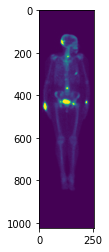

In [29]:
denoised = ndimage.median_filter(pixelArray, size=3);
plt.imshow(denoised);
#sigma_est = np.mean(estimate_sigma(pixelArray, multichannel=False))
#patch_kw = dict(patch_size=5,patch_distance=6,multichannel=False)

# denoised = denoise_nl_means(pixelArray, h=1.15 * sigma_est, fast_mode=False,**patch_kw)

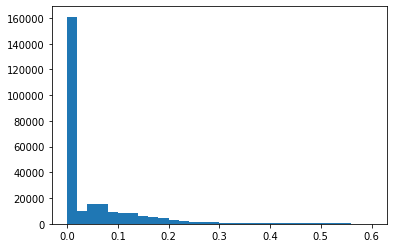

In [30]:
eq = exposure.equalize_adapthist(denoised);
plt.hist(eq.flat, bins=30, range=(0, 0.6));

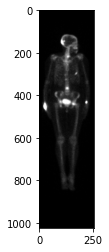

In [4]:
plt.imshow(eq, cmap='gray');

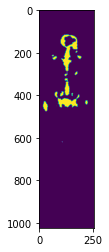

In [31]:
markers = np.zeros(eq.shape, dtype=np.uint);
markers[(eq < 0.1)] = 1;
markers[(eq > 0.1) & (eq < 0.25)] = 2;
markers[(eq >= 0.3)] = 3;

labels = random_walker(eq, markers, beta=10, mode='bf');
bone = (labels == 2);
met = (labels == 3);
#plt.imshow(met);
#plt.imshow(bone);

segmented = np.zeros(eq.shape, dtype=np.float);
segmented[met] = eq[met];
plt.imshow(met);

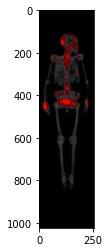

In [26]:
false_colors = np.zeros((rows, cols, 3), dtype=np.uint8);
for i in range(rows):
    for j in range(cols):
        if met[i,j]:
            false_colors[i,j] = (eq[i,j] * 255, 0, 0);
        if bone[i,j]:
            intensity = eq[i,j] * 255;
            false_colors[i,j] = (intensity, intensity, intensity);
plt.imshow(false_colors);

In [35]:
edge_roberts = roberts(segmented);
edge_sobel = sobel(segmented);
edge_scharr = scharr(segmented);
edge_prewitt = prewitt(segmented);
cv2.imshow('roberts', edge_roberts);
cv2.imshow('sobel', edge_sobel);
cv2.imshow('sobel', edge_sobel);
cv2.imshow('scharr', edge_scharr);
cv2.imshow('prewitt', edge_prewitt);
cv2.waitKey(0);
cv2.destroyAllWindows();

In [ ]:
cv2.imshow('denoised and equalized', eq);
cv2.imshow('segmented', segmented);
cv2.imshow('false colors', cv2.cvtColor(false_colors, cv2.COLOR_RGB2BGR)); 
cv2.imshow('org', pixelArray);
cv2.waitKey(0);
cv2.destroyAllWindows();